In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift
import scipy.signal
import matplotlib.pyplot as plt

In [2]:
SAMP_RATE = 50e6 # samples per second
FFT_SIZE = 65536*4*4*4 # bins
TIME = 0.1 # seconds of recording

raw = np.fromfile('./data/own/IQREC-02-03-19-13h38m31s479.iq', dtype='int16')
raw = raw[0 : len(raw) : 2] + 1.0j * raw[0 : len(raw) : 2]
raw = raw[0:int(TIME * SAMP_RATE)]

In [3]:
def plot_spect(sig, fs, window='nuttall', noverlap=256*8*2, nperseg=512*8*2, nfft=2048*16*8):
    '''Plot the power spectrum of a signal over time (waterfall plot)'''
    f, t, Sxx = scipy.signal.spectrogram(sig, fs=fs, window='nuttall',
                                     noverlap=256*8, nperseg=512*8,
                                     nfft=2048*16*8*2*4)
    plt.pcolormesh(f, t, Sxx.T)
    plt.ylabel('time')
    plt.xlabel('freq')
    plt.show()
    plt.close()


def np2(n):
    '''Find the next power 2 number (for FFT)'''
    lg = np.log2(n)
    if lg != int(lg):
        lg = int(lg) + 1
    return int(np.power(2, lg))


def delay_sig(datin, shift):
    '''Delay a signal by shift samples'''
    Nin = len(datin) 
    N = np2(Nin +np.max(np.abs(shift)))
    fdatin = fft(datin, N)
    ik = np.array([2j*np.pi*k for k in range(0, N)]) / N 
    fshift = np.exp(-ik*shift)
    datout = np.real(np.fft.ifft(fshift * fdatin))
    datout = datout[0:Nin]
    return datout


def xcorr(x, y):
    return ifft(fft(x) * np.conj(fft(y))).real

def mfreqz(b,a=1):
    '''Plot frequency and phase response of a filter'''
    w,h = scipy.signal.freqz(b,a)
    h_dB = 20 * np.log10 (abs(h))
    plt.subplot(211)
    plt.plot(w/max(w),h_dB)
    plt.ylim(-150, 5)
    plt.ylabel('Magnitude (db)')
    plt.xlabel(r'Normalized Frequency (x$\pi$rad/sample)')
    plt.title(r'Frequency response')
    plt.subplot(212)
    h_Phase = np.unwrap(np.arctan2(np.imag(h),np.real(h)))
    plt.plot(w/max(w),h_Phase)
    plt.ylabel('Phase (radians)')
    plt.xlabel(r'Normalized Frequency (x$\pi$rad/sample)')
    plt.title(r'Phase response')
    plt.subplots_adjust(hspace=0.5)


def impz(b,a=1):
    '''Plot step and impulse response of the filter'''
    l = len(b)
    impulse = np.repeat(0.,l); impulse[0] =1.
    x = np.arange(0,l)
    response = scipy.signal.lfilter(b,a,impulse)
    plt.subplot(211)
    plt.stem(x, response)
    plt.ylabel('Amplitude')
    plt.xlabel(r'n (samples)')
    plt.title(r'Impulse response')
    plt.subplot(212)
    step = cumsum(response)
    plt.stem(x, step)
    plt.ylabel('Amplitude')
    plt.xlabel(r'n (samples)')
    plt.title(r'Step response')
    plt.subplots_adjust(hspace=0.5)


def design_bandpass(ntaps, cutoff=0.5, window='blackmanharris'):  
    hpf = scipy.signal.firwin(ntaps, cutoff=cutoff, window=window)
    lpf = -scipy.signal.firwin(ntaps, cutoff=cutoff-0.1, window=window)
    lpf[int(ntaps/2)] += 1
    
    bpf = -(hpf + lpf)
    bpf[int(ntaps/2)] += 1
    
    return bpf


def design_remez(n, cfreq, passw, stop_l, stop_h, samp_freq):
    '''
    Design a FIR filter with the following parameters using the
    Remez exchange algorithm.
    
    cfreq: Center Frequency
    passw: Passband width (passband is [cfreq - passw, cfreq + passw])
    samp_freq: Sampling frequency
    '''
    bands = np.array([0, stop_l, cfreq - passw, cfreq + passw, stop_h, samp_freq/2])
    bpf = scipy.signal.remez(n, bands, [0, 1, 0], fs=samp_freq, type='bandpass')
    return bpf

In [4]:
# plot_spect(sc[0:2**15], 50e6, noverlap=256*8*2, nperseg=512*8*2*4*4, nfft=2048*16*8*4*4)

In [5]:
NOISE_DB = 45 # dB
TX_DB = 15 # dB
ts = np.linspace(0, TIME, TIME*SAMP_RATE, endpoint=False)
chirp = scipy.signal.chirp(ts, f0=2e6, t1=TIME, f1=20e6 * 1.3, method='linear')
sig = np.power(10, TX_DB / 10)*(chirp.copy() / np.max(chirp)) + np.power(10, NOISE_DB / 10)*(raw / np.max(raw))

/home/rytse/anaconda3/envs/irss/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


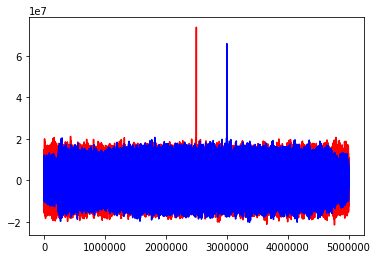

500000

In [6]:
cor1 = xcorr(sig, chirp)
delayed = delay_sig(sig, 5000*100)
cor2 = xcorr(delayed, chirp)

plt.plot(fftshift(cor1), c='r')
plt.plot(fftshift(cor2), c='b')
plt.show()

np.argmax(cor2)